## Note:

I will be following the same notation and assumptions estiablished in the notebook titled "logisitic_equation_two_param_grid".
It is repeated below to improve readability.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from scipy.stats import norm
import statsmodels.stats.api as sms

from IPython.display import HTML

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

Suppose we are given a set of data and we know it is created from a logistic style differential equation.
 We want to estimate the parameter $\lambda$ and $K$ from the data. First, we know the form of the solution of the differential equation, namely : $$ x(t) = \frac{Ce^{\lambda t}}{1 + \frac{C}{K}e^{\lambda t}}, \quad C=\frac{Kx(0)}{K-x(0)}$$.

When the differential equation takes the form of : $$\frac{dx}{dt} = \lambda x(1 - \frac{x}{K}), \quad \text{with} \quad x(0)=x_0 $$. 


## Priors and Model

We want to specify pior distributions for the parameters $\lambda$ and $K$. Here, they are a priori independent.


$$ \lambda \sim \text{N}(\mu_0, \sigma_0^2) \quad \text{and} \quad K \sim \text{Norm} ( \mu_1, \sigma_1^2) $$

We will generate some random experimental data of m observations, $\mathbf{y}$ below. We assume that this data is normally distributed around the true solution of the logistic equation with a known variance.

$$ y_i = x(t_i) + \epsilon_i $$ where $\epsilon_i, ..., \epsilon_m \sim  \text{Norm} ( 0 , \tau^2) $$

In [6]:
random.seed(2018)
mu_0 = 1
mu_1 = 5.0
sig_0 = 0.3
sig_1 = 1

true_lambda = np.random.normal(mu_0, sig_0)

true_K = np.random.normal(mu_1, sig_1)

t_values = np.linspace(-5,15,51)

def diff_eqn_solution(true_lambda, carry_cap, t):
    return np.exp(true_lambda*t)/(1 + (1/true_K)*np.exp(true_lambda*t))

In [7]:
# Simulating what the true solution would be then adding the simulated gaussian noise 

sim_df = pd.DataFrame(index=t_values)
sim_df["true_values"] = diff_eqn_solution(true_lambda, true_K, sim_df.index)
sim_df["sim_values"] = np.zeros(len(sim_df.index))

tau = 0.3

for index, row in sim_df.iterrows():
    sim_df.loc[index, "sim_values"] = sim_df.loc[index, "true_values"] + np.random.normal(0, tau)

In [8]:
sim_df.head()

,true_values,sim_values
-5.0,0.000282,-0.193204
-4.6,0.000542,-0.073298
-4.2,0.001043,0.256739
-3.8,0.002005,-0.285166
-3.4,0.003854,-0.108150


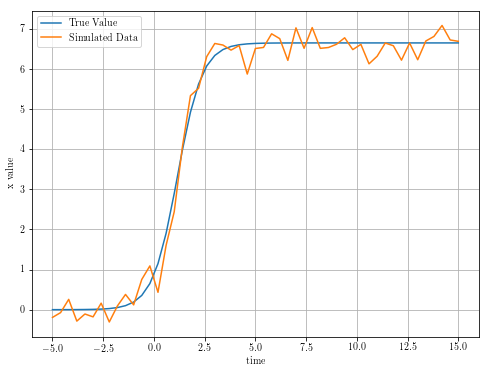

In [9]:
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 8
fig_size[1] = 6

plt.plot(sim_df["true_values"])
plt.plot(sim_df["sim_values"])
plt.grid(True)
plt.xlabel("time")
plt.ylabel("x value")
plt.legend(["True Value", "Simulated Data"])
plt.show()

## Likelihood

$$ p(\lambda, K \mid \mathbf{y}) = \frac{p(\mathbf{y} \mid K, \lambda) p(K, \lambda)}{p(\mathbf{y})} =  \frac{p(\mathbf{y} \mid K, \lambda) p(K) p(\lambda)}{p(\mathbf{y})}$$

Now, we define the likelihood distribution. $Y_1, Y_2,..., Y_m$ are the random variables of the realisations/experimental data $ \mathbf{y} = (y_1, y_2,..., y_m)$ so that:

$$ Y_i \mid K, \lambda \sim \text{Norm}( x(t_i), \tau^2) $$

We can therefore simplify our posterior from:

$$ p(\lambda, K \mid \mathbf{y}) \propto p(\lambda, K)p(\mathbf{y} \mid \lambda, K) $$

to:

$$ p(\lambda, K \mid \mathbf{y}) \propto p(\lambda)p(K)\Pi_{i=1}^m \text{N}(x(t_i), \tau^2) $$

In [10]:
def likelihood(observation, lambda_value, k_value, t):
    return norm.pdf(observation, diff_eqn_solution(lambda_value, k_value, t), tau)

like_vec = np.vectorize(likelihood)

## Posterior via MCMC (Metropolis Hastings)

Below I will briefly describe the MH algorithm that will be implemented. Firstly we wish to sample from the the target distribution $p(\lambda, K \mid \mathbf{y})$ which we do so by following the following algorithm. 

Suppose we have a state $X^{(t)} = (K^{(t)}, \lambda^{(t)})$ then we generate a new sample using a proposal distribution $q$.


Generate $Y^{(t)} \sim q(y \mid X^{(t)})$

Move to the new position $X^{(t+1)}$, where:

$X^{(t+1)} = Y^{(t)}$ with probability $\alpha$ 


$ \quad \quad \quad X^{(t)}$ with probability $ 1-\alpha $


Where 

$\alpha = \text{min}\left{ 1, \frac{p((K^{(t+1)}, \lambda^{(t+1)} \mid \mathbf{y})}{p(K^{(t)}, \lambda^{(t)} \mid \mathbf{y})} \right$

In this example we will define our proposal distribution by a Guassian with mean of the current state and a diagonal covariance matrix $\Sigma^2$, that is:

$$ Y^{(t)} \sim N(X^{(t)}, \Sigma^2) $$

In [32]:
def mh_posterior(likelihood, prior):
    return likelihood*prior

def mh_prior(lambda_val, k_val):
    #Remembering that in this case we assumed that our priors are independent apriori.
    return norm.pdf(lambda_val, mu_0, sig_0)*norm.pdf(k_val, mu_1, sig_1)

def mh_likelihood(sim_df):
    product = 1.0
    for i in range(len(sim_df)):
        t = round(sim_df.index[1], 1)
        product = product * norm.pdf(sim_df["sim_values"][i], diff_eqn_solution(true_lambda, true_K, t))
        
def q_dist(x_t, C):
    #proposal distribution from state x_t with meant x_t and covar matrix C
    return np.random.mutltivariate_norm(x_t, C)